In [26]:
import h5py
from pathlib import Path
import numpy as np

N = 2
path = Path(f'../data/raw/eventhdr/eval/{N}.h5')
COMBINE_FRAMES = 5
SIMULATE_EVENTS = False

with h5py.File(path, "r") as file:
    p = np.array(file['events/ps'])
    t = np.array(file['events/ts'])
    x = np.array(file['events/xs'])
    y = np.array(file['events/ys'])
    frame_ts = []
    all_frame_ts = []
    print(file.attrs.keys())
    # print(file.attrs['duration'])
    print(file.attrs.get('source', 'unknown'))
    frames = []
    all_frames = []
    resolution = file.attrs.get('sensor_resolution')
    for i, img_name in enumerate(file['images']):
        all_frame_ts.append(file[f'images/{img_name}'].attrs['timestamp'])
        all_frames.append(np.array(file['images'][img_name]))
        if i % COMBINE_FRAMES != 0:
            continue
        frame_ts.append(file[f'images/{img_name}'].attrs['timestamp'])
        frames.append(np.array(file['images'][img_name]))


<KeysViewHDF5 ['duration', 'num_events', 'num_flow', 'num_imgs', 'num_neg', 'num_pos', 'sensor_resolution', 't0', 'tk']>
unknown


In [27]:
from dynamic_fusion.utils.image import scale_to_quantiles
from dynamic_fusion.utils.video import normalize


if SIMULATE_EVENTS:
    import evs_explorer

    from dynamic_fusion.data_generator.event_generator import ImageGenerator

    all_frames_np = np.stack(all_frames).astype(np.float64)
    all_frames_np = scale_to_quantiles(all_frames_np, [0,1,2], q_low=0.01, q_high=0.99)
    exponentiated_images = np.exp(all_frames_np.copy() * 0.7)
    exponentiated_images = normalize(exponentiated_images)


    EVS_EXPLORER_CONFIG = "../configs/data_generator/simulator/evs_explorer.yml"
    DAVIS_CONFIG = "../configs/data_generator/simulator/davis_model.yml"
    THRESHOLD = 1.35
    MIN_ILLUMINANCE = 650
    MAX_ILLUMINANCE = 12500

    image_generator = ImageGenerator(data=exponentiated_images*255, fps=500, num_frames=len(all_frames))


    scfg = evs_explorer.Configuration.from_yaml(
        simulator_config=EVS_EXPLORER_CONFIG,
        sensor_config=DAVIS_CONFIG,
        sensor_model="davis_model",
    )

    scfg.input.source = image_generator
    scfg.optics.max_illuminance_lux = MAX_ILLUMINANCE
    scfg.optics.min_illuminance_lux = MIN_ILLUMINANCE
    scfg.sensor.ONth_mul = THRESHOLD
    scfg.sensor.OFFth_mul = THRESHOLD

    evs_explorer = evs_explorer.EvsExplorer(scfg)
    events = evs_explorer.run("sensor_data")
    print(len(events))

In [28]:
from dynamic_fusion.utils.image import scale_to_quantiles

frames_np = np.stack(frames).astype(np.float32)
frames_quant = scale_to_quantiles(frames_np, [0,1,2], q_low=0.01, q_high=0.99)

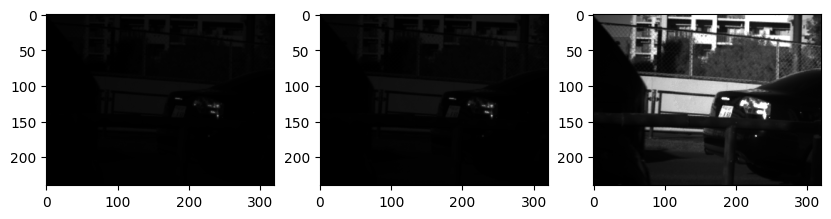

In [29]:
from matplotlib import pyplot as plt

max_val = max(frame.max() for frame in frames)
frames_norm = [frame / max_val for frame in frames]
I = 55

frame = frames[I]
frame_norm = frames_norm[I]
frame_quant = frames_quant[I]

fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].imshow(frame , cmap = 'gray', vmin=0, vmax = 255*255)
axs[1].imshow(frame_norm, cmap = 'gray', vmin=0, vmax = 1)
axs[2].imshow(frame_quant, cmap = 'gray', vmin=0, vmax = 1)

In [30]:
import pandas as pd
if not SIMULATE_EVENTS:
    events = pd.DataFrame({"timestamp": t, "x": x, "y": y, "polarity": p})
else:
    events.timestamp += t[0]
events['frame_bin'] = pd.cut(events.timestamp, frame_ts, labels=False, right = False)

In [31]:
from dynamic_fusion.utils.discretized_events import DiscretizedEvents
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer

THRESHOLD = 1.35
config = EventDiscretizerConfiguration(number_of_temporal_bins=1, number_of_temporal_sub_bins_per_bin=2)
discretizer = EventDiscretizer(config, max_timestamp=1.)

discretized_frames = []

for frame_bin, events_in_frame in events.groupby("frame_bin"):
    frame_bin = int(frame_bin)
    timestamp_range = (frame_ts[frame_bin], frame_ts[frame_bin + 1])

    assert np.all((events_in_frame.timestamp < timestamp_range[1]) & (events_in_frame.timestamp >= timestamp_range[0]))
    events_in_frame.timestamp -= timestamp_range[0]
    events_in_frame.timestamp /= timestamp_range[1] - timestamp_range[0]
    discretized_frame = discretizer._discretize_events(events_in_frame, THRESHOLD, resolution)
    discretized_frames.append(discretized_frame)

In [32]:
import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader


MODEL = "e2vid_exp"
# MODEL = "e2vid_exp_uncertainty"
# MODEL = "old"

if MODEL == "e2vid_exp":
    CHECKPOINT_DIR = Path("../runs/0323-new-dataset/01_st-un_st-interp_st-up/subrun_00")
elif MODEL == "e2vid_exp_uncertainty":
    CHECKPOINT_DIR = Path("../runs/0323-new-dataset/00_st-un_st-interp_st-up_uncertainty-lpips/subrun_00")
elif MODEL == "old":
    CHECKPOINT_DIR = Path("../runs/0306-fixed")

device = torch.device("cuda")

CHECKPOINT_NAME = "latest_checkpoint.pt"


config_path = CHECKPOINT_DIR / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)
# Load network
config.network_loader.decoding_checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
config.network_loader.encoding_checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [33]:
from dynamic_fusion.scripts.test_e2vid_data import run_reconstruction
from dynamic_fusion.utils.discretized_events import DiscretizedEvents


discretized_events = DiscretizedEvents.stack_temporally(discretized_frames)
reconstruction = run_reconstruction(encoder, decoder, discretized_events, device, config.shared)

reconstruction_norm = reconstruction.copy()

# reconstruction_norm[:,0] = scale_to_quantiles(reconstruction_norm[:,0], [0,1,2], q_low=0.01, q_high=0.99)

Loading pretrained model LPIPS from /home/davton/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
0.2711571626962678


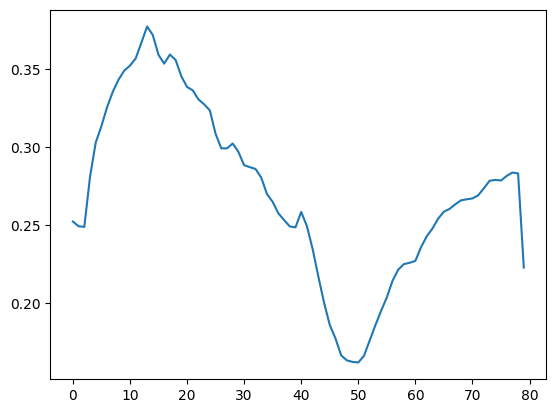











100%|██████████| 80/80 [00:00<00:00, 162.16it/s]


tensor(0.4903)


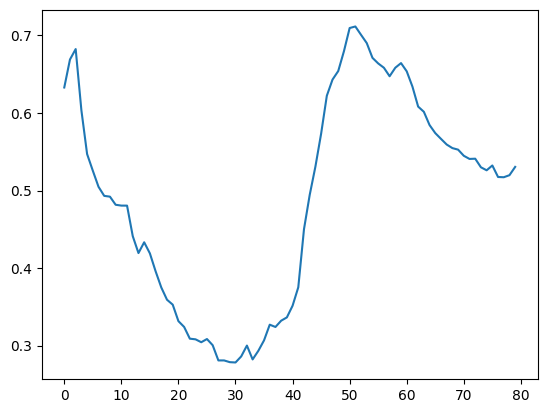

: 

In [34]:
import cv2
from skimage.color import rgb2gray
import numpy as np
from skimage.metrics import structural_similarity as ssim
from dynamic_fusion.utils.loss import LPIPS

from tqdm import tqdm
from dynamic_fusion.utils.video import normalize

import einops
from jaxtyping import Float

def get_iqa(pyiqa_metric, x: Float[torch.Tensor, "B C X Y"], y: Float[torch.Tensor, "B C X Y"]):
    x = einops.repeat(x, "B C X Y -> B (C three) X Y", three=3)
    y = einops.repeat(y, "B C X Y -> B (C three) X Y", three=3)

    return pyiqa_metric(x, y)
import pyiqa

lpips = pyiqa.create_metric('lpips', device=device)

ssim_vals = [ssim(reconstruction_norm[i,0], frames_quant[i], data_range=1) for i in range(len(reconstruction_norm))]
print(sum(ssim_vals) / len(ssim_vals))

from matplotlib import pyplot as plt

plt.plot(ssim_vals)
plt.show()


lpips_vals = []
# lpips = LPIPS().to(device)


for i in tqdm(range(len(reconstruction_norm))):
    recon_tensor = torch.tensor(reconstruction_norm[i, 0:1][None]).to(device).float()
    image_tensor = torch.tensor(frames_quant[i][None, None]).to(device).float()
    # lpips_vals.append(lpips(recon_tensor, image_tensor).item())
    lpips_vals.append(get_iqa(lpips, recon_tensor, image_tensor).cpu())

from matplotlib import pyplot as plt

print(sum(lpips_vals) / len(lpips_vals))

plt.plot(lpips_vals)
plt.show()

In [20]:
from dynamic_fusion.utils.network import to_numpy
from dynamic_fusion.utils.plotting import discretized_events_to_cv2_frame, add_text_at_row
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap
# Create a figure and a set of subplots

directory = Path(f"../data/raw/eventhdr/{N}")


def log_std_to_cv2_frame(log_std, min_std = 0.05, max_std = 0.5):
    min_log, max_log = np.log(min_std), np.log(max_std)

    clipped_log_std = np.clip(log_std, min_log, max_log)
    normalized_log_std = (clipped_log_std - min_log) / (max_log - min_log)
    
    frame = cv2.cvtColor((normalized_log_std*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    add_text_at_row(frame, f"std, {[min_std, max_std]}, log", 0)
    return frame


output_dir = Path(f'../results/eventhdr_test_{SIMULATE_EVENTS=}_{COMBINE_FRAMES=}/')
output_dir.mkdir(parents=True,exist_ok=True)
SPEED = 0.5
size = discretized_events.event_polarity_sum.shape
multiplier = 3 + int(reconstruction_norm.shape[1] > 1)
out = cv2.VideoWriter(f"{str(output_dir)}/{N}.mp4", cv2.VideoWriter.fourcc(*"mp4v"), int(len(discretized_events.event_polarity_sum)/(events.timestamp.max() - events.timestamp.min())*SPEED), (size[-1]*multiplier, size[-2]))
colored_event_polarity_sums = img_to_colormap(to_numpy(discretized_events.event_polarity_sum.sum(dim=1)), create_red_blue_cmap(501))
for I in range(len(reconstruction_norm)):
    event_frame = discretized_events_to_cv2_frame(colored_event_polarity_sums[I], discretized_events.event_count[I])
    recon_frame = cv2.cvtColor((reconstruction_norm[I, 0]*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    gt_frame = cv2.cvtColor((frames_quant[I]*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    add_text_at_row(recon_frame, f"LPIPS={lpips_vals[I]:.2f}", 0)
    add_text_at_row(recon_frame, f"SSIM={ssim_vals[I]:.2f}", 1)

    if reconstruction_norm.shape[1] == 2:
        std_frame = log_std_to_cv2_frame(reconstruction_norm[I, 1])
        frame = np.concatenate([event_frame, recon_frame, gt_frame, std_frame], axis=1)
    else:
        frame = np.concatenate([event_frame, recon_frame, gt_frame], axis=1)

    out.write(frame)

out.release()

In [46]:
print(discretized_events.event_count.sum(axis=1).mean(axis=(0,1)))
print(discretized_events.event_count.sum(axis=1).mean(axis=(0,1)).sum())

tensor([0.4923, 0.4561, 0.4809, 0.4816, 0.4996, 0.4780, 0.4852, 0.4476, 0.4699,
        0.4675, 0.4911, 0.4738, 0.4863, 0.4620, 0.4680, 0.4646, 0.4822, 0.4684,
        0.4814, 0.4759, 0.5142, 0.5054, 0.4874, 0.4729, 0.4978, 0.4629, 0.4789,
        0.4710, 0.4840, 0.4820, 0.4651, 0.4663, 0.4750, 0.4734, 0.4733, 0.4650,
        0.4756, 0.4593, 0.4647, 0.4560, 0.4779, 0.4563, 0.4783, 0.4714, 0.4789,
        0.4851, 0.5081, 0.4732, 0.4951, 0.4714, 0.4722, 0.4741, 0.5150, 0.4878,
        0.5203, 0.4855, 0.5174, 0.4998, 0.5217, 0.5026, 0.5226, 0.4961, 0.5144,
        0.4899, 0.5472, 0.4971, 0.5317, 0.5261, 0.5257, 0.5103, 0.5392, 0.5061,
        0.5434, 0.5097, 0.5230, 0.5062, 0.5172, 0.4933, 0.5132, 0.4959, 0.5448,
        0.5431, 0.5446, 0.5216, 0.5583, 0.5323, 0.5645, 0.5496, 0.5653, 0.5317,
        0.5583, 0.5499, 0.5631, 0.5480, 0.5799, 0.5317, 0.5754, 0.5523, 0.5686,
        0.5470, 0.5652, 0.5484, 0.5669, 0.5577, 0.5615, 0.5425, 0.5623, 0.5482,
        0.5649, 0.5565, 0.5603, 0.5357, 

In [56]:
print(discretized_events.event_count.sum(axis=1).mean(axis=(0,1)))
print(discretized_events.event_count.sum(axis=1).mean(axis=(0,1)).sum())

tensor([0.5565, 0.6436, 0.5770, 0.6410, 0.5832, 0.6452, 0.5775, 0.6436, 0.5829,
        0.6454, 0.5844, 0.6471, 0.5798, 0.6456, 0.5791, 0.6395, 0.5717, 0.6415,
        0.5764, 0.6319, 0.5713, 0.6308, 0.5667, 0.6296, 0.5644, 0.6356, 0.5750,
        0.6263, 0.5696, 0.6342, 0.5717, 0.6285, 0.5753, 0.6381, 0.5759, 0.6341,
        0.5704, 0.6323, 0.5661, 0.6365, 0.5704, 0.6353, 0.5741, 0.6293, 0.5782,
        0.6373, 0.5758, 0.6310, 0.5805, 0.6476, 0.5835, 0.6439, 0.5831, 0.6488,
        0.5873, 0.6477, 0.5968, 0.6622, 0.6028, 0.6611, 0.5974, 0.6548, 0.6008,
        0.6582, 0.5931, 0.6679, 0.6070, 0.6674, 0.5940, 0.6633, 0.5902, 0.6571,
        0.5983, 0.6583, 0.5988, 0.6568, 0.5952, 0.6590, 0.5904, 0.6664, 0.6044,
        0.6708, 0.6079, 0.6757, 0.6066, 0.6757, 0.6066, 0.6750, 0.6103, 0.6867,
        0.6177, 0.6810, 0.6076, 0.6882, 0.6119, 0.6805, 0.6199, 0.6912, 0.6149,
        0.6854, 0.6221, 0.6910, 0.6096, 0.6872, 0.6105, 0.6892, 0.6138, 0.6816,
        0.6122, 0.6765, 0.6172, 0.6808, 